# Warehouse Optimization - Big Experiment

**Parametry:**
- Mapa: 9×9
- Agenti: 1
- Populace: 100
- Generace: 50

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import time

from warehouse import Warehouse, OrderGenerator
from mapd_solver import MAPDSimulator
from surrogate import SurrogateModel, extract_features, compare_models
from evolution import run_evolution, collect_initial_data
from baselines import run_all_baselines

%matplotlib inline

In [18]:
# Parametry experimentu
GRID_SIZE = 9
N_AGENTS = 1
SIM_STEPS = 100
ORDER_LAMBDA = 0.3
SEED = 42

# EA parametry
POP_SIZE = 30
N_GENERATIONS = 100
REAL_EVAL_INTERVAL = 10

# Surrogate parametry
INIT_SAMPLES = 100

## 1. Vytvoření skladu

In [19]:
wh = Warehouse(GRID_SIZE, GRID_SIZE)
og = OrderGenerator(wh.n_inner, seed=SEED)

print(f"Velikost: {GRID_SIZE}x{GRID_SIZE}")
print(f"Počet vnitřních pozic (zboží): {wh.n_inner}")
print(f"Počet delivery points: {len(wh.get_delivery_points())}")

Velikost: 9x9
Počet vnitřních pozic (zboží): 49
Počet delivery points: 32


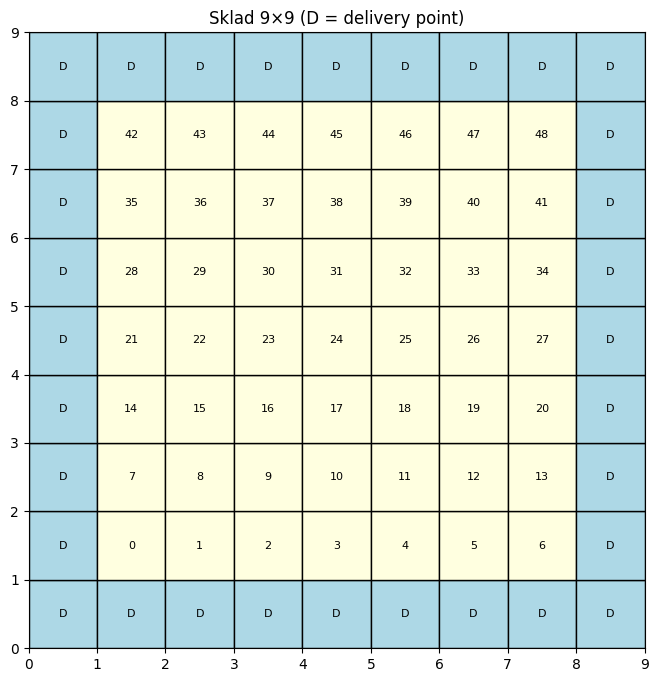

In [20]:
# Vizualizace prázdného skladu
fig, ax = plt.subplots(figsize=(8, 8))

for y in range(GRID_SIZE):
    for x in range(GRID_SIZE):
        if x == 0 or x == GRID_SIZE-1 or y == 0 or y == GRID_SIZE-1:
            color = 'lightblue'
            label = 'D'
        else:
            color = 'lightyellow'
            inner_idx = (y - 1) * (GRID_SIZE - 2) + (x - 1)
            label = str(inner_idx)
        
        ax.add_patch(plt.Rectangle((x, y), 1, 1, facecolor=color, edgecolor='black'))
        ax.text(x + 0.5, y + 0.5, label, ha='center', va='center', fontsize=8)

ax.set_xlim(0, GRID_SIZE)
ax.set_ylim(0, GRID_SIZE)
ax.set_aspect('equal')
ax.set_title(f'Sklad {GRID_SIZE}×{GRID_SIZE} (D = delivery point)')
plt.show()

## 2. Baseline metody

In [21]:
baseline_results = run_all_baselines(
    wh, og, n_agents=N_AGENTS,
    random_samples=50,
    sim_steps=SIM_STEPS,
    order_lambda=ORDER_LAMBDA,
    seed=SEED,
    verbose=True
)

Running baselines...

1. Random baseline:
  Random: 20/50 samples, best so far: 0.1700
  Random: 40/50 samples, best so far: 0.1900

2. Greedy baseline:
  Greedy fitness: 0.1500

3. Inverse greedy baseline:
  Inverse greedy fitness: 0.1200


In [22]:
print("Souhrn baseline:")
print(f"  Random:         best={baseline_results['random']['best_fitness']:.4f}, "
      f"mean={baseline_results['random']['mean_fitness']:.4f}")
print(f"  Greedy:         {baseline_results['greedy']['fitness']:.4f}")
print(f"  Inverse Greedy: {baseline_results['inverse_greedy']['fitness']:.4f}")

Souhrn baseline:
  Random:         best=0.2000, mean=0.1376
  Greedy:         0.1500
  Inverse Greedy: 0.1200


## 3. Sběr dat pro surrogate model

In [23]:
print(f"Sbírám {INIT_SAMPLES} vzorků...")
start_time = time.time()

features_list, fitness_list, layouts_list = collect_initial_data(
    wh, og, n_agents=N_AGENTS,
    n_samples=INIT_SAMPLES,
    sim_steps=SIM_STEPS,
    order_lambda=ORDER_LAMBDA,
    seed=SEED,
    verbose=True
)

collect_time = time.time() - start_time
print(f"\nČas sběru dat: {collect_time:.1f}s")

X_data = np.array(features_list)
y_data = np.array(fitness_list)

print(f"Rozsah fitness: [{y_data.min():.4f}, {y_data.max():.4f}]")
print(f"Průměr fitness: {y_data.mean():.4f} ± {y_data.std():.4f}")

Sbírám 100 vzorků...
  Collected 10/100 samples
  Collected 20/100 samples
  Collected 30/100 samples
  Collected 40/100 samples
  Collected 50/100 samples
  Collected 60/100 samples
  Collected 70/100 samples
  Collected 80/100 samples
  Collected 90/100 samples
  Collected 100/100 samples

Čas sběru dat: 29.8s
Rozsah fitness: [0.0900, 0.2000]
Průměr fitness: 0.1340 ± 0.0208


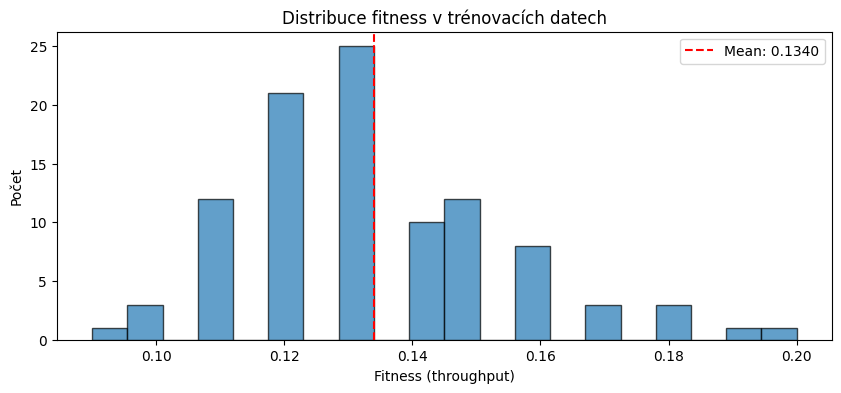

In [24]:
# Histogram fitness hodnot
plt.figure(figsize=(10, 4))
plt.hist(y_data, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(y_data.mean(), color='red', linestyle='--', label=f'Mean: {y_data.mean():.4f}')
plt.xlabel('Fitness (throughput)')
plt.ylabel('Počet')
plt.title('Distribuce fitness v trénovacích datech')
plt.legend()
plt.show()

## 4. Porovnání surrogate modelů

In [25]:
model_comparison = compare_models(X_data, y_data, cv=5)

print("Cross-validation R² skóre:")
for name, scores in model_comparison.items():
    print(f"  {name:10s}: {scores['r2_mean']:.3f} ± {scores['r2_std']:.3f}")

# Vyber nejlepší model
best_model_name = max(model_comparison.keys(),
                      key=lambda k: model_comparison[k]['r2_mean'])
print(f"\nNejlepší model: {best_model_name}")

Cross-validation R² skóre:
  linear    : 0.013 ± 0.210
  gp        : 0.036 ± 0.152
  rf        : 0.136 ± 0.178

Nejlepší model: rf


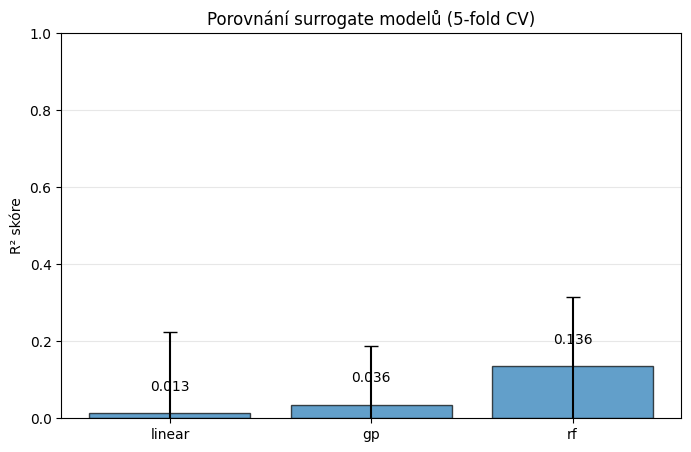

In [26]:
# Vizualizace R² skóre
fig, ax = plt.subplots(figsize=(8, 5))

names = list(model_comparison.keys())
means = [model_comparison[n]['r2_mean'] for n in names]
stds = [model_comparison[n]['r2_std'] for n in names]

bars = ax.bar(names, means, yerr=stds, capsize=5, alpha=0.7, edgecolor='black')
ax.set_ylabel('R² skóre')
ax.set_title('Porovnání surrogate modelů (5-fold CV)')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')

for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            f'{mean:.3f}', ha='center', va='bottom')

plt.show()

## 5. Evoluce BEZ surrogate

In [27]:
print(f"Populace: {POP_SIZE}, Generace: {N_GENERATIONS}")
print("Toto může trvat déle...\n")

ea_no_surrogate = run_evolution(
    wh, og, n_agents=N_AGENTS,
    n_generations=N_GENERATIONS,
    pop_size=POP_SIZE,
    use_surrogate=False,
    sim_steps=SIM_STEPS,
    order_lambda=ORDER_LAMBDA,
    seed=SEED,
    verbose=True
)

print(f"\nVýsledky bez surrogate:")
print(f"  Nejlepší fitness: {ea_no_surrogate['best_fitness']:.4f}")
print(f"  Reálných evaluací: {ea_no_surrogate['real_evals']}")
print(f"  Čas: {ea_no_surrogate['wall_time']:.1f}s")

Populace: 30, Generace: 100
Toto může trvat déle...

Gen 0: best=0.1900, avg=0.1290, std=0.0204
Gen 10: best=0.1900, avg=0.1510
Gen 20: best=0.2100, avg=0.1653
Gen 30: best=0.2300, avg=0.1820
Gen 40: best=0.2000, avg=0.1433
Gen 50: best=0.2100, avg=0.1600
Gen 60: best=0.1900, avg=0.1503
Gen 70: best=0.2300, avg=0.1547
Gen 80: best=0.2300, avg=0.1493
Gen 90: best=0.1900, avg=0.1490
Gen 100: best=0.2400, avg=0.1513

Výsledky bez surrogate:
  Nejlepší fitness: 0.2600
  Reálných evaluací: 3030
  Čas: 696.0s


## 6. Evoluce SE surrogate

In [28]:
print(f"Populace: {POP_SIZE}, Generace: {N_GENERATIONS}")
print(f"Surrogate model: {best_model_name}")
print(f"Reálná evaluace každých {REAL_EVAL_INTERVAL} generací\n")

ea_with_surrogate = run_evolution(
    wh, og, n_agents=N_AGENTS,
    n_generations=N_GENERATIONS,
    pop_size=POP_SIZE,
    use_surrogate=True,
    surrogate_type=best_model_name,
    real_eval_interval=REAL_EVAL_INTERVAL,
    sim_steps=SIM_STEPS,
    order_lambda=ORDER_LAMBDA,
    seed=SEED,
    verbose=True
)

print(f"\nVýsledky se surrogate:")
print(f"  Nejlepší fitness: {ea_with_surrogate['best_fitness']:.4f}")
print(f"  Reálných evaluací: {ea_with_surrogate['real_evals']}")
print(f"  Surrogate evaluací: {ea_with_surrogate['surrogate_evals']}")
print(f"  Čas: {ea_with_surrogate['wall_time']:.1f}s")

Populace: 30, Generace: 100
Surrogate model: rf
Reálná evaluace každých 10 generací

Gen 0: best=0.1900, avg=0.1417, std=0.0173
Gen 10: best=0.2000, avg=0.1488, real_evals=50
Gen 20: best=0.1800, avg=0.1444, real_evals=72
Gen 30: best=0.1900, avg=0.1494, real_evals=91
Gen 40: best=0.1800, avg=0.1493, real_evals=113
Gen 50: best=0.2400, avg=0.1643, real_evals=137
Gen 60: best=0.2100, avg=0.1591, real_evals=159
Gen 70: best=0.2100, avg=0.1676, real_evals=180
Gen 80: best=0.2200, avg=0.1642, real_evals=207
Gen 90: best=0.2400, avg=0.1861, real_evals=236
Gen 100: best=0.2700, avg=0.1912, real_evals=256

Výsledky se surrogate:
  Nejlepší fitness: 0.2700
  Reálných evaluací: 256
  Surrogate evaluací: 2097
  Čas: 91.6s


## 7. Finální porovnání

In [29]:
print(f"{'Metoda':<20} {'Fitness':>10} {'Real evals':>12} {'Čas':>10}")
print("-" * 55)

results_table = [
    ("Random (best)", baseline_results['random']['best_fitness'], "-", "-"),
    ("Random (mean)", baseline_results['random']['mean_fitness'], "-", "-"),
    ("Greedy", baseline_results['greedy']['fitness'], "-", "-"),
    ("Inverse Greedy", baseline_results['inverse_greedy']['fitness'], "-", "-"),
    ("EA bez surrogate", ea_no_surrogate['best_fitness'],
     ea_no_surrogate['real_evals'], f"{ea_no_surrogate['wall_time']:.1f}s"),
    ("EA se surrogate", ea_with_surrogate['best_fitness'],
     ea_with_surrogate['real_evals'], f"{ea_with_surrogate['wall_time']:.1f}s"),
]

for name, fitness, evals, time_str in results_table:
    print(f"{name:<20} {fitness:>10.4f} {str(evals):>12} {str(time_str):>10}")

# Úspora evaluací
savings = (1 - ea_with_surrogate['real_evals'] / ea_no_surrogate['real_evals']) * 100
print(f"\nÚspora reálných evaluací: {savings:.1f}%")

# Speedup
speedup = ea_no_surrogate['wall_time'] / ea_with_surrogate['wall_time']
print(f"Speedup: {speedup:.2f}x")

Metoda                  Fitness   Real evals        Čas
-------------------------------------------------------
Random (best)            0.2000            -          -
Random (mean)            0.1376            -          -
Greedy                   0.1500            -          -
Inverse Greedy           0.1200            -          -
EA bez surrogate         0.2600         3030     696.0s
EA se surrogate          0.2700          256      91.6s

Úspora reálných evaluací: 91.6%
Speedup: 7.60x


## 8. Vizualizace výsledků

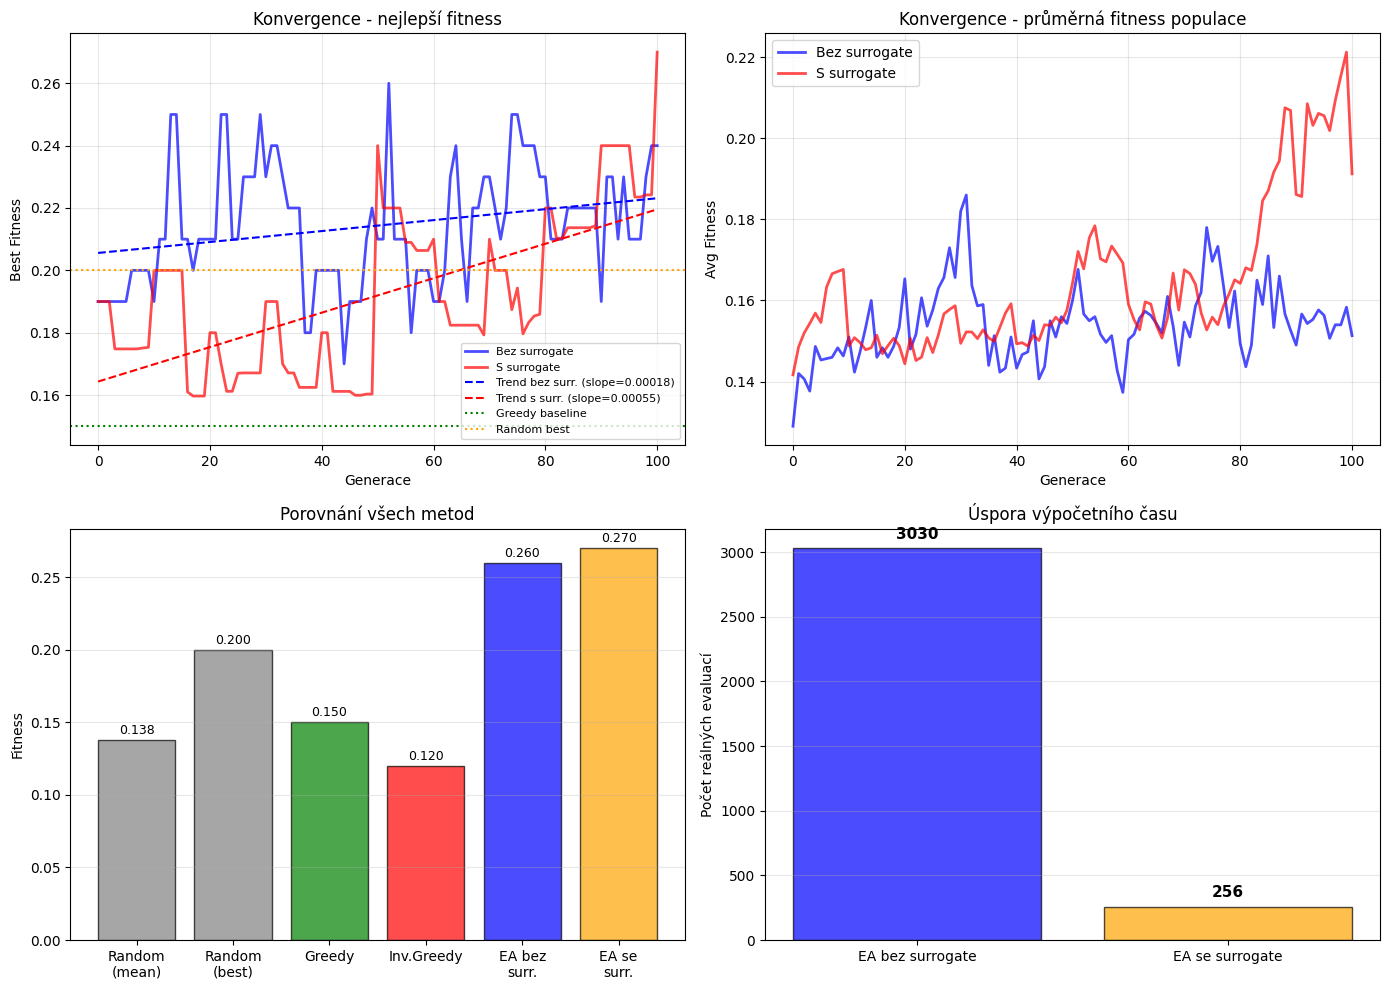

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Graf 1: Konvergence - best fitness
ax1 = axes[0, 0]
gens = np.arange(len(ea_no_surrogate['fitness_history']))
ax1.plot(gens, ea_no_surrogate['fitness_history'], 'b-',
         label='Bez surrogate', linewidth=2, alpha=0.7)
ax1.plot(gens, ea_with_surrogate['fitness_history'], 'r-',
         label='S surrogate', linewidth=2, alpha=0.7)

# Lineární fit
z1 = np.polyfit(gens, ea_no_surrogate['fitness_history'], 1)
z2 = np.polyfit(gens, ea_with_surrogate['fitness_history'], 1)
ax1.plot(gens, np.poly1d(z1)(gens), 'b--', linewidth=1.5,
         label=f'Trend bez surr. (slope={z1[0]:.5f})')
ax1.plot(gens, np.poly1d(z2)(gens), 'r--', linewidth=1.5,
         label=f'Trend s surr. (slope={z2[0]:.5f})')

# Baseline čáry
ax1.axhline(y=baseline_results['greedy']['fitness'], color='g',
            linestyle=':', label='Greedy baseline')
ax1.axhline(y=baseline_results['random']['best_fitness'], color='orange',
            linestyle=':', label='Random best')

ax1.set_xlabel('Generace')
ax1.set_ylabel('Best Fitness')
ax1.set_title('Konvergence - nejlepší fitness')
ax1.legend(loc='lower right', fontsize=8)
ax1.grid(True, alpha=0.3)

# Graf 2: Konvergence - avg fitness
ax2 = axes[0, 1]
ax2.plot(gens, ea_no_surrogate['avg_fitness_history'], 'b-',
         label='Bez surrogate', linewidth=2, alpha=0.7)
ax2.plot(gens, ea_with_surrogate['avg_fitness_history'], 'r-',
         label='S surrogate', linewidth=2, alpha=0.7)
ax2.set_xlabel('Generace')
ax2.set_ylabel('Avg Fitness')
ax2.set_title('Konvergence - průměrná fitness populace')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Graf 3: Porovnání metod (bar chart)
ax3 = axes[1, 0]
methods = ['Random\n(mean)', 'Random\n(best)', 'Greedy', 'Inv.Greedy',
           'EA bez\nsurr.', 'EA se\nsurr.']
values = [
    baseline_results['random']['mean_fitness'],
    baseline_results['random']['best_fitness'],
    baseline_results['greedy']['fitness'],
    baseline_results['inverse_greedy']['fitness'],
    ea_no_surrogate['best_fitness'],
    ea_with_surrogate['best_fitness']
]
colors = ['gray', 'gray', 'green', 'red', 'blue', 'orange']
bars = ax3.bar(methods, values, color=colors, alpha=0.7, edgecolor='black')
ax3.set_ylabel('Fitness')
ax3.set_title('Porovnání všech metod')
ax3.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
            f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# Graf 4: Počet reálných evaluací
ax4 = axes[1, 1]
eval_methods = ['EA bez surrogate', 'EA se surrogate']
eval_counts = [ea_no_surrogate['real_evals'], ea_with_surrogate['real_evals']]
bars = ax4.bar(eval_methods, eval_counts, color=['blue', 'orange'],
               alpha=0.7, edgecolor='black')
ax4.set_ylabel('Počet reálných evaluací')
ax4.set_title('Úspora výpočetního času')
ax4.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, eval_counts):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{val}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('project_big_results.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Vizualizace nejlepšího rozložení

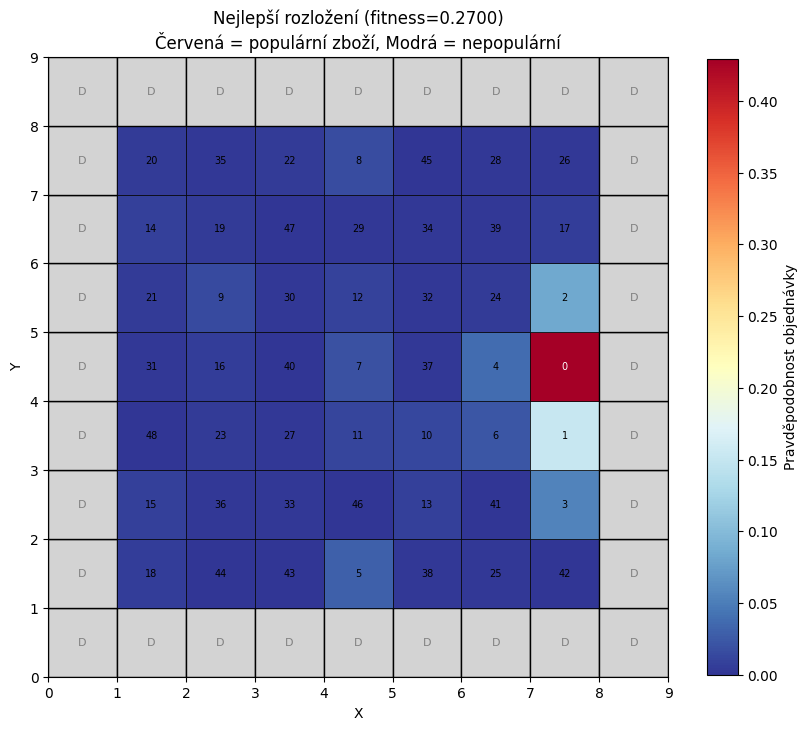

In [31]:
# Najdi nejlepší řešení
best_layout = ea_with_surrogate['best_individual']
wh.set_layout(best_layout)

fig, ax = plt.subplots(figsize=(10, 10))
probs = og.get_probabilities()

# Vykreslení gridu
for y in range(GRID_SIZE):
    for x in range(GRID_SIZE):
        # Okraj = delivery points (šedá)
        if x == 0 or x == GRID_SIZE-1 or y == 0 or y == GRID_SIZE-1:
            color = 'lightgray'
            ax.add_patch(plt.Rectangle((x, y), 1, 1,
                        facecolor=color, edgecolor='black', linewidth=1))
            ax.text(x + 0.5, y + 0.5, 'D', ha='center', va='center',
                   fontsize=8, color='gray')
        else:
            # Vnitřní pozice - barva podle popularity zboží
            inner_idx = (y - 1) * (GRID_SIZE - 2) + (x - 1)
            goods_id = best_layout[inner_idx]
            prob = probs[goods_id]

            # Barva: červená = vysoká popularita, modrá = nízká
            intensity = prob / probs.max()
            color = plt.cm.RdYlBu_r(intensity)

            ax.add_patch(plt.Rectangle((x, y), 1, 1,
                        facecolor=color, edgecolor='black', linewidth=0.5))
            ax.text(x + 0.5, y + 0.5, f'{goods_id}', ha='center', va='center',
                   fontsize=7, color='white' if intensity > 0.5 else 'black')

ax.set_xlim(0, GRID_SIZE)
ax.set_ylim(0, GRID_SIZE)
ax.set_aspect('equal')
ax.set_title(f'Nejlepší rozložení (fitness={ea_with_surrogate["best_fitness"]:.4f})\n'
             f'Červená = populární zboží, Modrá = nepopulární')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu_r,
                            norm=plt.Normalize(vmin=0, vmax=probs.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label('Pravděpodobnost objednávky')

plt.savefig('project_big_best_layout.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Závěr

### Shrnutí výsledků

- **Surrogate model** výrazně snižuje počet reálných simulací
- **Speedup** díky surrogate modelu
- **Kvalita řešení** srovnatelná nebo lepší než bez surrogate

In [32]:
print("=" * 50)
print("EXPERIMENT DOKONČEN")
print("=" * 50)
print(f"\nNejlepší fitness (EA se surrogate): {ea_with_surrogate['best_fitness']:.4f}")
print(f"Úspora evaluací: {savings:.1f}%")
print(f"Speedup: {speedup:.2f}x")

EXPERIMENT DOKONČEN

Nejlepší fitness (EA se surrogate): 0.2700
Úspora evaluací: 91.6%
Speedup: 7.60x
